In [ ]:
#######################################################################################
# Author: Srijan Verma                                                              #
# School of Pharmacy                                                                #
# Sirimulla Research Group [http://www.sirimullaresearchgroup.com/]                 #
# The University of Texas at El Paso, TX, USA                                       #
# Last modified: 19/12/2019                                                         #
# Copyright (c) 2019 Srijan Verma and Sirimulla Research Group, under MIT license   #
#######################################################################################

In [184]:
import pandas as pd
import sys
# sys.path.append("../../LigandNet/scripts")
sys.path.append("../utilities/")
from utility import FeatureGenerator
import os
import pandas as pd
from pandas import DataFrame,Series
from sklearn import tree
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
# import statsmodels.formula.api as smf
# import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn import neighbors
from sklearn import linear_model
%matplotlib inline

In [91]:
from rdkit import Chem
from rdkit.Chem import AllChem

In [92]:
def get_ecfp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    ecfp = AllChem.GetMorganFingerprintAsBitVect(mol, 3).ToBitString()
    return [int(s) for s in ecfp]

In [187]:
nbits = 1024
longbits = 16384
class FeatureTypeNotSupported(Exception):
    """ Raised when the provided feature type is not supported"""
    pass

class Dataset:
    # Supported feature types
    _feature_types = ["ecfp-6"]
    X = None
    y = None
    _df = pd.DataFrame()
    _smiles_field = None
    _target_field = None
    _bits = None
    smiles = None
    targets = None
    
    def __init__(self, df, smiles_field, target_field,bits):
        # clean the dataset
        self._df = df if len(df)>0 else None
        self._smiles_field = smiles_field
        self._target_field = target_field
        self._bits = bits
        
        # Clean the data
        self._clean_data()
        
        # Populate the smiles and target list
        self._get_smiles_targets()
    
    def _get_smiles_targets(self):
        self.smiles = self._df[self._smiles_field].values.tolist()
        self.targets = self._df[self._target_field].values.tolist()
        
    def _clean_data(self):
        if self._df is None: return
        # Drop Nan values
        # self._df = df.dropna(axis=0)
        # Check the target field
        self._df = self._df[np.isfinite(self._df[self._target_field])]
        
    def _get_ecfp6(self, smiles, bits):
        mol = Chem.MolFromSmiles(smiles)
        ecfp = AllChem.GetMorganFingerprintAsBitVect(mol, 3,nBits=bits).ToBitString()
        return [int(s) for s in ecfp]
    
    def create_dataset(self,bits,feature_type="ecfp-6"):
        if feature_type not in self._feature_types:
            raise FeatureTypeNotSupported("Feature type is not supported.")
        self.X = np.array([self._get_ecfp6(s,bits) for s in self.smiles], dtype=np.float32)
        self.y = np.array(self.targets, dtype=np.float32)

In [188]:
data_df = pd.read_csv("data/curated_data.csv")
data_df.head()

,CMPD_CHEMBLID,COMPOUND_KEY,MOLWEIGHT,ALOGP,PSA,CANONICAL_SMILES,Km,Vmax,pKm
0,CHEMBL300797,L-tyrosine methyl ester,195.22,0.43,72.55,COC(=O)[C@@H](N)Cc1ccc(O)cc1,4000000.0,350.0,-15.201805
1,CHEMBL1288,1-Naphthalenemethanol,158.20,2.33,20.23,OCc1cccc2ccccc12,30000.0,26.0,-10.308953
2,CHEMBL14060,Phenol,94.11,1.39,20.23,Oc1ccccc1,19000.0,350.0,-9.852194
3,CHEMBL14126,2-naphthol,144.17,2.55,20.23,Oc1ccc2ccccc2c1,8000.0,1130.0,-8.987197
4,CHEMBL3085280,4-ethylbenzyl alcohol,488.55,0.27,163.53,N[C@@H](C(=O)NC1C2SCC(=C(N2C1=O)C(=O)O)CSc3c[n...,60000.0,182.0,-11.002100


In [189]:
len(data_df)

167

In [190]:
# # Extract features
# def get_features(SMILES):
#     try:
#         feat_gen = FeatureGenerator(SMILES)
#         return feat_gen.toTPATF()
#     except Exception as e:
#         print(str(e))
#         return float('NaN')

### Model for Km

In [191]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.externals import joblib
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn import linear_model
%matplotlib inline

In [180]:
random_state = 1

In [237]:
dataset = Dataset(data_df,bits=1024, smiles_field="CANONICAL_SMILES", target_field="Vmax")
dataset.create_dataset(1024)
train_x, test_x, train_y, test_y = train_test_split(dataset.X, dataset.y, test_size=0.2, random_state = random_state)
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(42, 1024) (42,) (11, 1024) (11,)


In [225]:
train_y[0]

-13.3847275

In [238]:
params = {"n_estimators": [i for i in range(10, 101, 10)], 
          "oob_score": [True, False], 
          "n_jobs": [-1], 
          "random_state": [random_state]}
rf_clf = RandomForestRegressor()
rf_clf = linear_model.Ridge()
rf_clf = linear_model.BayesianRidge()
grid_clf = GridSearchCV(rf_clf, param_grid=params)
# grid_clf.fit(train_x, train_y)
rf_clf.fit(train_x, train_y)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=0.001, verbose=False)

In [217]:
n_neighbors=5
knn=neighbors.KNeighborsRegressor(n_neighbors,weights='uniform')
ridge = linear_model.Ridge()
reg = linear_model.BayesianRidge()
dec = tree.DecisionTreeRegressor(max_depth=1)
svm_reg=svm.SVR()
models = [knn,ridge,reg,dec,svm_reg]

In [236]:
from tqdm import tqdm_notebook
for clf in tqdm_notebook(models):
    for b in (1024,2048,16384):
        
        dataset = Dataset(data_df,bits=b, smiles_field="CANONICAL_SMILES", target_field="Vmax")
        dataset.create_dataset(b)
        train_x, test_x, train_y, test_y = train_test_split(dataset.X, dataset.y, test_size=0.2, random_state = random_state)
        clf.fit(train_x, train_y)
        train_pred = clf.predict(train_x)
        train_r2 = r2_score(y_pred=train_pred, y_true=train_y)
        test_pred = clf.predict(test_x)
        test_r2 = r2_score(y_pred=test_pred, y_true=test_y)
        print(clf.__class__.__name__,train_r2, test_r2, b)

KNeighborsRegressor 0.41714386185655217 0.17815455038820616 1024
KNeighborsRegressor 0.3713306646681188 0.16170803246369847 2048
KNeighborsRegressor 0.3383306604662295 -0.05579401654517957 16384
Ridge 0.9816828889682258 0.7046692619124004 1024
Ridge 0.9813651286446791 0.7032786157857941 2048
Ridge 0.9814012259826846 0.6662674062269602 16384
BayesianRidge 0.9821884056277422 0.7060551093702054 1024
BayesianRidge 0.9810841437729921 0.7025768455256929 2048
BayesianRidge 0.9806892670208223 0.6651462294075767 16384
DecisionTreeRegressor 0.6004916840177262 -0.014861400939806702 1024
DecisionTreeRegressor 0.6004916840177262 -0.014861400939806702 2048
DecisionTreeRegressor 0.6004916840177262 -0.014861400939806702 16384
SVR -0.07331814431936179 -0.09672846853768213 1024
SVR -0.07327558646600751 -0.09678507448979135 2048


/Users/pankajverma/anaconda3/envs/seqcomhol/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/pankajverma/anaconda3/envs/seqcomhol/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR -0.07320308699080158 -0.09680193400566894 16384



/Users/pankajverma/anaconda3/envs/seqcomhol/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [239]:
# clf = grid_clf.best_estimator_
clf = rf_clf

In [130]:
clf = grid_clf.best_estimator_
clf

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [240]:
train_pred = clf.predict(train_x)
train_r2 = r2_score(y_pred=train_pred, y_true=train_y)
test_pred = clf.predict(test_x)
test_r2 = r2_score(y_pred=test_pred, y_true=test_y)
print(train_r2, test_r2)

0.9821884056277422 0.7060551093702054


In [241]:
train_pred = clf.predict(train_x)
train_r2 = r2_score(y_pred=train_pred, y_true=train_y)
test_pred = clf.predict(test_x)
test_r2 = r2_score(y_pred=test_pred, y_true=test_y)
print(train_r2, test_r2)

0.9821884056277422 0.7060551093702054


In [242]:
train_pred = clf.predict(train_x)
train_r2 = r2_score(y_pred=train_pred, y_true=train_y)
test_pred = clf.predict(test_x)
test_r2 = r2_score(y_pred=test_pred, y_true=test_y)
print(train_r2, test_r2)

0.9821884056277422 0.7060551093702054


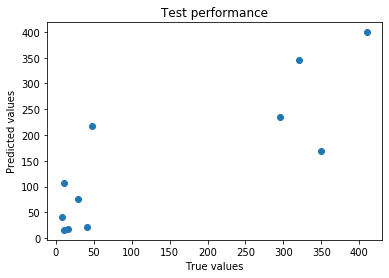

In [243]:
plt.figure()
plt.scatter(test_y, test_pred)
plt.title("Test performance")
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.show()

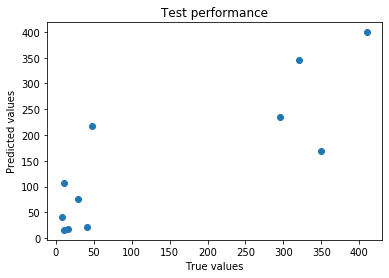

In [248]:
plt.figure()
plt.scatter(test_y, test_pred)
plt.title("Test performance")
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.savefig('vmax_test.png',dpi=1200)
plt.show()


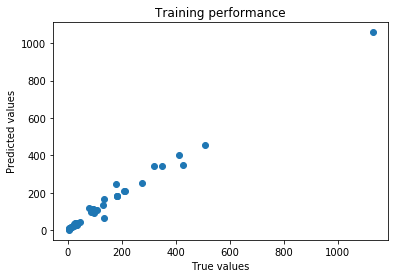

In [247]:
plt.figure()
plt.scatter(train_y, train_pred)
plt.title("Training performance")
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.savefig('vmax_train.png',dpi=1200)
plt.show()

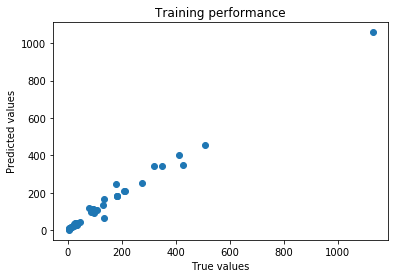

In [246]:
plt.figure()
plt.scatter(train_y, train_pred)
plt.title("Training performance")
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.show()

In [82]:
joblib.dump(clf, "Km_model.clf")

['Km_model.clf']

### Vmax Model

In [83]:
dataset = Dataset(data_df, smiles_field="CANONICAL_SMILES", target_field="Vmax")
dataset.create_dataset()
train_x, test_x, train_y, test_y = train_test_split(dataset.X, dataset.y, test_size=0.2)
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(42, 16384) (42,) (11, 16384) (11,)


In [84]:
params = {"n_estimators": [i for i in range(10, 101, 10)], "oob_score": [True, False], "n_jobs": [-1], "random_state": [1]}
rf_clf = RandomForestRegressor(verbose=True)
grid_clf = GridSearchCV(rf_clf, param_grid=params)
grid_clf.fit(train_x, train_y)

/Users/pankajverma/anaconda3/envs/seqcomhol/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished
/Users/pankajverma/anaconda3/envs/seqcomhol/lib/python3.6/site-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 co

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | ela

[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:    0.0s finished
[P

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=True, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'n_estimators': [10, 20

In [85]:
clf = grid_clf.best_estimator_
clf

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
                      oob_score=True, random_state=1, verbose=True,
                      warm_start=False)

In [87]:
train_pred = clf.predict(train_x)
train_r2 = r2_score(y_pred=train_pred, y_true=train_y)
test_pred = clf.predict(test_x)
test_r2 = r2_score(y_pred=test_pred, y_true=test_y)
print(train_r2, test_r2)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished


0.9360824493402954 -0.6757400202687252


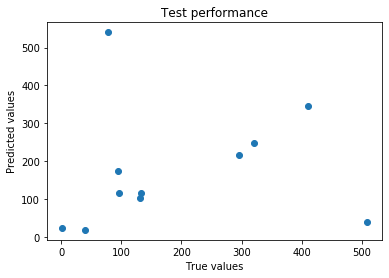

In [88]:
plt.figure()
plt.scatter(test_y, test_pred)
plt.title("Test performance")
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.show()

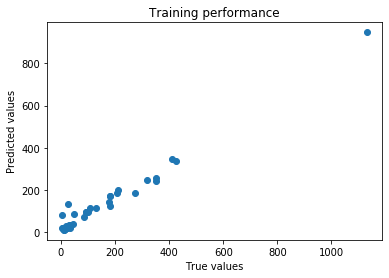

In [89]:
plt.figure()
plt.scatter(train_y, train_pred)
plt.title("Training performance")
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.show()

In [201]:
joblib.dump(clf, "vmax_model.clf")

['vmax_model.clf']